In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Generate synthetic data
np.random.seed(42)  # For reproducibility
epsilon = np.random.rand(100)
x = np.random.uniform(-1, 1, size=(100,))
y_low = x**2 - 0.3*epsilon**2
y_up = x**2 + 0.3*epsilon**2

# Create features and labels
X_low = np.column_stack((x, y_low))  # Features for class 0
X_up  = np.column_stack((x, y_up))  # Features for class 1
X = np.vstack((X_low, X_up))  # Combine both classes
y = np.array([0] * 100 + [1] * 100)  # Labels

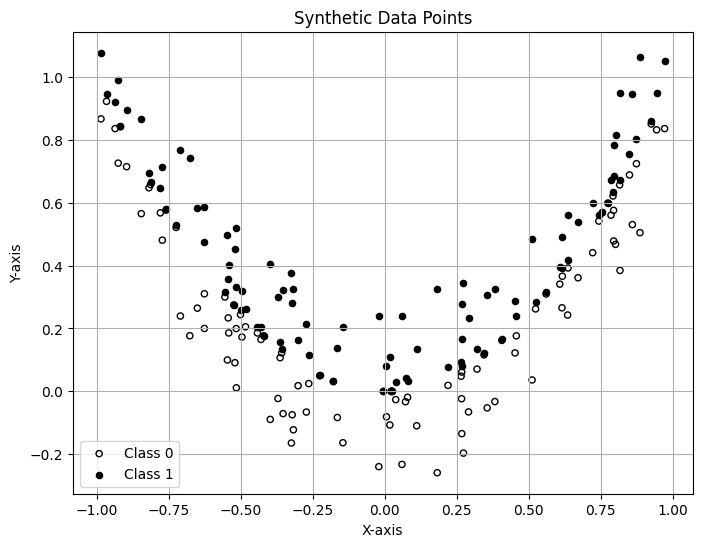

In [3]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], facecolors='none', edgecolor='black', label='Class 0', s=20)  # Hollow points for class 0
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='black', label='Class 1', s=20)  # Solid points for class 1

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Synthetic Data Points')
plt.legend()
plt.grid()
plt.show()

In [4]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [5]:
# Initialize model, loss function, and optimizer
model = MLP(input_size=2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).view(-1, 1)

# Training the model
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 0.1919
Epoch [2000/10000], Loss: 0.1666
Epoch [3000/10000], Loss: 0.1602
Epoch [4000/10000], Loss: 0.1579
Epoch [5000/10000], Loss: 0.1569
Epoch [6000/10000], Loss: 0.1563
Epoch [7000/10000], Loss: 0.1560
Epoch [8000/10000], Loss: 0.1559
Epoch [9000/10000], Loss: 0.1558
Epoch [10000/10000], Loss: 0.1556


In [6]:
# Define your model
def model_output(x, y):
    input_tensor = torch.tensor([x, y]).float()
    output = model(input_tensor)  # Replace this with your model call
    return output.item()

def interval_reg(i):
    x, _ = X_tensor[i]
    x, _  = X_tensor[i + 100]

    y_low = -1
    y_up = 2

    # Bisection method to find where output equals 0.5
    tolerance = 1e-5  # Set a small tolerance for convergence
    max_iterations = 100  # Limit the number of iterations

    for _ in range(max_iterations):
        y_mid = (y_low + y_up) / 2  # Calculate the midpoint
        output = model_output(x, y_mid)

        if abs(output - 0.5) < tolerance:  # Check if we're close enough to 0.5
            y_0_5 = y_mid  # Store the midpoint as the solution
            break
        elif output < 0.5:
            y_low = y_mid  # Move the lower bound up
        else:
            y_up = y_mid  # Move the upper bound down
    
    return y_0_5

In [7]:
predictions = []
for i in range(100):
    predictions.append(interval_reg(i))
predictions = np.array(predictions)

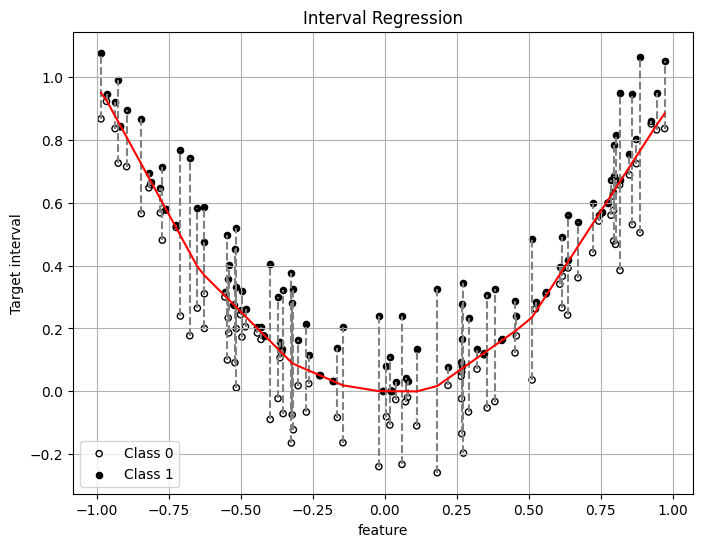

In [9]:
# Assuming x, predictions, X, and y are defined
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
predictions_sorted = predictions[sorted_indices]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], facecolors='none', edgecolor='black', label='Class 0', s=20)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='black', label='Class 1', s=20)

# Draw vertical lines from Class 0 to Class 1
for i in range(len(X[y == 0])):
    plt.plot([X[y == 0][i, 0], X[y == 1][i, 0]], [X[y == 0][i, 1], X[y == 1][i, 1]], color='gray', linestyle='--')

plt.plot(x_sorted, predictions_sorted, color='red')

plt.xlabel('feature')
plt.ylabel('Target interval')
plt.title('Interval Regression')
plt.legend()
plt.grid()
plt.show()